In [69]:
from typing import List, TypedDict, Literal
from pydantic import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langchain_community.tools.tavily_search import TavilySearchResults


from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [70]:
docs = (
    PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Policies.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Profile.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Product_and_Pricing.pdf").load()
)

In [71]:
chunks = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=150
).split_documents(docs)

In [72]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

In [73]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [74]:
class State(TypedDict):
    question: str
    need_retrieval: bool

    docs: List[Document]
    relevant_docs: List[Document]

    context: str
    answer: str

    # web query (no loop flags)
    web_query: str

In [75]:
class RetrieveDecision(BaseModel):
    should_retrieve: bool = Field(
        ...,
        description="True if external documents are needed to answer reliably, else False."
    )

decide_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You decide whether retrieval is needed.\n"
            "Return JSON that matches this schema:\n"
            "{{'should_retrieve': boolean}}\n\n"
            "Guidelines:\n"
            "- should_retrieve=True if answering requires specific facts, citations, or info likely not in the model.\n"
            "- should_retrieve=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
            "- If unsure, choose True."
        ),
        ("human", "Question: {question}"),
    ]
)


# IMPORTANT: no `.content` for structured output
should_retrieve_llm = llm.with_structured_output(RetrieveDecision)

import json
import ast

def decide_retrieval(state: "State"):
    prompt = decide_retrieval_prompt.format_prompt(question=state["question"])
    response = llm.invoke(prompt)
    content = response.content.strip()
    print("LLM response:", content)  # Debug print

    try:
        return {"need_retrieval": json.loads(content)["should_retrieve"]}
    except Exception:
        try:
            return {"need_retrieval": ast.literal_eval(content)["should_retrieve"]}
        except Exception:
            # Handle 'should_retrieve: True' or similar
            if "True" in content:
                return {"need_retrieval": True}
            elif "False" in content:
                return {"need_retrieval": False}
            else:
                raise ValueError("Could not parse LLM output: " + content)


In [76]:
direct_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "'I don't know based on my general knowledge.'"
        ),
        ("human", "{question}"),
    ]
)


def generate_direct(state: State):
    out = llm.invoke(
        direct_generation_prompt.format_messages(
            question=state["question"]
        )
    )
    return {
        "answer": out.content
    }

In [77]:
def retrieve(state: State):
    return {"docs": retriever.invoke(state["question"])}

In [78]:
# -----------------------------
# 4) Relevance filter 
# -----------------------------
class RelevanceDecision(BaseModel):
    is_relevant: bool = Field(
        ...,
        description="True ONLY if the document contains info that can directly answer the question."
    )

is_relevant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging document relevance at a TOPIC level.\n"
            "Return JSON matching the schema.\n\n"
            "A document is relevant if it discusses the same entity or topic area as the question.\n"
            "It does NOT need to contain the exact answer.\n\n"
            "Examples:\n"
            "- HR policies are relevant to questions about notice period, probation, termination, benefits.\n"
            "- Pricing documents are relevant to questions about refunds, trials, billing terms.\n"
            "- Company profile is relevant to questions about leadership, culture, size, or strategy.\n\n"
            "Do NOT decide whether the document fully answers the question.\n"
            "That will be checked later by IsSUP.\n"
            "When unsure, return is_relevant=true."
        ),
        ("human", "Question:\n{question}\n\nDocument:\n{document}"),
    ]
)


relevance_llm = llm.with_structured_output(RelevanceDecision)

def is_relevant(state: State):
    relevant_docs: List[Document] = []
    for doc in state["docs"]:
        prompt = is_relevant_prompt.format_prompt(
            question=state["question"],
            document=doc.page_content
        )
        response = llm.invoke(prompt)
        content = response.content.strip()
        print("LLM response:", content)  # Debug print

        try:
            decision = json.loads(content)
        except Exception:
            # Try to fix common issues
            content_fixed = content.replace("'", "\"")
            if content_fixed.startswith("{") and content_fixed.endswith("}"):
                try:
                    decision = json.loads(content_fixed)
                except Exception:
                    decision = None
            else:
                # Handle 'is_relevant: True' or similar
                if "True" in content or "False" in content:
                    val = "True" in content
                    decision = {"is_relevant": val}
                else:
                    decision = None

        if decision and decision.get("is_relevant"):
            relevant_docs.append(doc)
    return {"relevant_docs": relevant_docs}


In [79]:
# New
rag_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a business RAG assistant.\n"
            "Answer the user's question using ONLY the provided context.\n"
            "If the context does not contain enough information, say:\n"
            "'No relevant document found.'\n"
            "Do not use outside knowledge.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)

def generate_from_context(state: State):
    # Stuff relevant docs into one block
    context = "\n\n---\n\n".join(
        [d.page_content for d in state.get("relevant_docs", [])]
    ).strip()

    if not context:
        return {"answer": "No relevant document found.", "context": ""}

    out = llm.invoke(
        rag_generation_prompt.format_messages(
            question=state["question"],
            context=context
        )
    )
    return {"answer": out.content, "context": context}

In [80]:
class WebQuery(BaseModel):
    query: str

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Rewrite the user question into a web search query composed of keywords.\n"
            "Rules:\n"
            "- Keep it short (6–14 words).\n"
            "- If the question implies recency, add (last 30 days).\n"
            "- Do NOT answer the question.\n"
            "- Return JSON with a single key: query",
        ),
        ("human", "Question: {question}"),
    ]
)

rewrite_chain = rewrite_prompt | llm.with_structured_output(WebQuery)

def rewrite_query_node(state: State):
    prompt = rewrite_prompt.format_prompt(question=state["question"])
    response = llm.invoke(prompt)
    content = response.content.strip()
    # Add robust parsing here if expecting JSON
    # Example:
    try:
        result = json.loads(content)
        return {"web_query": result.get("query", "")}
    except Exception:
        return {"web_query": content}

tavily = TavilySearchResults(max_results=5)

def web_search_node(state: State):
    q = state.get("web_query") or state["question"]
    results = tavily.invoke({"query": q})

    docs = []
    for r in results or []:
        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"
        docs.append(
            Document(
                page_content=text,
                metadata={"source": "web", "url": url, "title": title},
            )
        )

    return {"docs": docs}

In [81]:
# New
def no_relevant_docs(state: State):
    return {"answer": "No relevant document found.", "context": ""}

In [82]:
def route_after_decide(state: State) -> Literal["generate_direct", "retrieve"]:
    if state["need_retrieval"]:
        return "retrieve"
    return "generate_direct"

In [83]:
def route_after_relevance(state: State) -> Literal["generate_from_context", "rewrite_query"]:
    if state.get("relevant_docs") and len(state["relevant_docs"]) > 0:
        return "generate_from_context"
    return "rewrite_query"

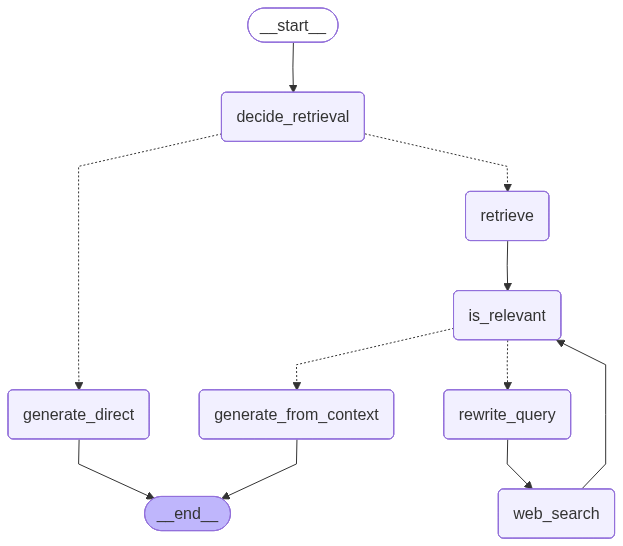

In [84]:
g = StateGraph(State)

g.add_node("decide_retrieval", decide_retrieval)
g.add_node("generate_direct", generate_direct)
g.add_node("retrieve", retrieve)

g.add_node("is_relevant", is_relevant)
g.add_node("generate_from_context", generate_from_context)

# ✅ new nodes (replace no_relevant_docs)
g.add_node("rewrite_query", rewrite_query_node)
g.add_node("web_search", web_search_node)

# --------------------
# Edges
# --------------------
g.add_edge(START, "decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",
    route_after_decide,
    {
        "generate_direct": "generate_direct",
        "retrieve": "retrieve",
    },
)

g.add_edge("generate_direct", END)

# vector retrieval → relevance
g.add_edge("retrieve", "is_relevant")

# relevance router: if relevant → generate, else → rewrite_query
g.add_conditional_edges(
    "is_relevant",
    route_after_relevance,
    {
        "generate_from_context": "generate_from_context",
        "rewrite_query": "rewrite_query",
    },
)

# web fallback path
g.add_edge("rewrite_query", "web_search")
g.add_edge("web_search", "is_relevant")  # 🔁 circle back

# final
g.add_edge("generate_from_context", END)

app = g.compile()
app

In [85]:
result = app.invoke(
    {
        "question": "Who won the Aus vs Zim World T20 match 2026 and who was the top scorer",
        "docs": [],
        "relevant_docs": [],
        "context": "",
        "answer": "",
    }
)

print(result["answer"])

LLM response: {'should_retrieve': True}
LLM response: ```json
{
  "is_relevant": false
}
```
LLM response: ```json
{
  "is_relevant": false
}
```
LLM response: ```json
{
  "is_relevant": false
}
```
LLM response: ```json
{
  "is_relevant": false
}
```
LLM response: ```json
{
  "is_relevant": true
}
```
LLM response: ```json
{
  "is_relevant": true
}
```
LLM response: ```json
{
  "is_relevant": true
}
```
LLM response: ```json
{
  "is_relevant": true
}
```
LLM response: {
  "is_relevant": true
}
No relevant document found.
